In [1]:
from voxelwise_tutorials.io import get_data_home

directory = get_data_home(dataset="shortclips")
print(directory)

/home/jlg/yuerou/voxelwise_tutorials_data/shortclips


In [2]:
# modify to use another subject
subject = "S01"

In [3]:
import os
import numpy as np
from voxelwise_tutorials.io import load_hdf5_array

file_name = os.path.join(directory, "responses", f"{subject}_responses.hdf")
Y_train = load_hdf5_array(file_name, key="Y_train")
Y_test = load_hdf5_array(file_name, key="Y_test")

print("(n_samples_train, n_voxels) =", Y_train.shape)
print("(n_repeats, n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (3600, 84038)
(n_repeats, n_samples_test, n_voxels) = (10, 270, 84038)


In [4]:
Y_test = Y_test.mean(0)

print("(n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_test, n_voxels) = (270, 84038)


In [5]:
Y_train = np.nan_to_num(Y_train)
Y_test = np.nan_to_num(Y_test)

In [6]:
feature_space = "wordnet"

file_name = os.path.join(directory, "features", f"{feature_space}.hdf")
X_train = load_hdf5_array(file_name, key="X_train")
X_test = load_hdf5_array(file_name, key="X_test")

print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_test, n_features) =", X_test.shape)

(n_samples_train, n_features) = (3600, 1705)
(n_samples_test, n_features) = (270, 1705)


In [7]:
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out

# indice of first sample of each run
run_onsets = load_hdf5_array(file_name, key="run_onsets")
print(run_onsets)

[   0  300  600  900 1200 1500 1800 2100 2400 2700 3000 3300]


In [8]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.ridge import RidgeCV
from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

alphas = np.logspace(1, 20, 20)

pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)

/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [10]:
from sklearn import set_config

set_config(display='diagram')  # requires scikit-learn 0.23
pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('delayer', Delayer(delays=[1, 2, 3, 4])),
                ('kernelridgecv',
                 KernelRidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                               cv=_CVIterableWrapper(cv=[(array([   0,    1, ..., 3598, 3599]), array..., (array([   0,    1, ..., 3598, 3599]), array([2700, 2701, ..., 2998, 2999])), (array([   0,    1, ..., 3598, 3599]), array([2400, 2401, ..., 2698, 2699])), (array([ 300,  301, ..., 3598, 3599]), array([  0,   1, ..., 298, ...1, ..., 1498, 1499])), (array([   0,    1, ..., 3298, 3299]), array([3300, 3301, ..., 3598, 3599]))]),
                               solver_params={'n_alphas_batch': 5,
                                              'n_targets_batch': 500,
                                              'n_targets_batch_refit': 100}))])

In [11]:
pipeline.fit(X_train, Y_train)

scores = pipeline.score(X_test, Y_test)
scores = backend.to_numpy(scores)
print("(n_voxels,) =", scores.shape)

(n_voxels,) = (84038,)


In [12]:
# number of total trs
n_trs = 50
# repetition time for the simulated data
TR = 2.0
rng = np.random.RandomState(42)
y = rng.randn(n_trs)
x = np.zeros(n_trs)
# add some arbitrary value to our feature
x[15:20] = .5
x += rng.randn(n_trs) * 0.1  # add some noise

# create a delayer object and delay the features
delayer = Delayer(delays=[0, 1, 2, 3, 4])
x_delayed = delayer.fit_transform(x[:, None])

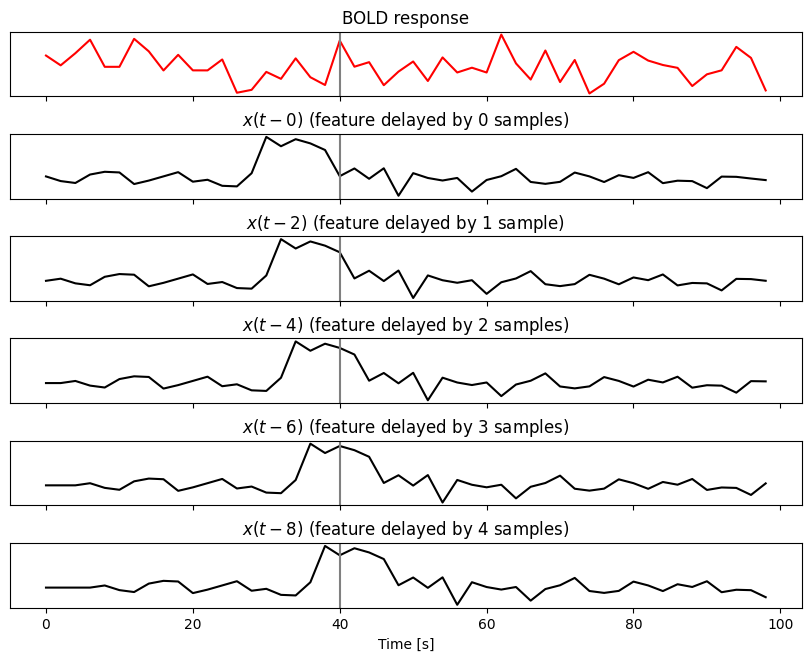

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 1, figsize=(8, 6.5), constrained_layout=True,
                        sharex=True)
times = np.arange(n_trs) * TR

axs[0].plot(times, y, color="r")
axs[0].set_title("BOLD response")
for i, (ax, xx) in enumerate(zip(axs.flat[1:], x_delayed.T)):
    ax.plot(times, xx, color='k')
    ax.set_title("$x(t - {0:.0f})$ (feature delayed by {1} sample{2})".format(
        i * TR, i, "" if i == 1 else "s"))
for ax in axs.flat:
    ax.axvline(40, color='gray')
    ax.set_yticks([])
_ = axs[-1].set_xlabel("Time [s]")
plt.show()

In [14]:
pipeline_no_delay = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    RidgeCV(
        alphas=alphas, cv=cv, solver="svd",
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)
pipeline_no_delay

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                         cv=_CVIterableWrapper(cv=[(array([   0,    1, ..., 3598, 3599]), array([300, 301, ..., 598, 599])), (array([   0,    1, ..., 3598, 3599]), array([2700, 2701, ..., 2998, 2999])), (array([   0,    1, ..., 3598, 3599]), array([2400, 2401, ..., 2698, 2699])), (array([ 300,  301, ..., 3598, 3599]), array([  0,   1, ..., 298, ...1, ..., 1498, 1499])), (array([   0,    1, ..., 3298, 3299]), array([3300, 3301, ..., 3598, 3599]))]),
                         solver_params={'n_alphas_batch': 5,
                                        'n_targets_batch': 500,
                                        'n_targets_batch_refit': 100}))])

In [15]:
pipeline_no_delay.fit(X_train, Y_train)
scores_no_delay = pipeline_no_delay.score(X_test, Y_test)
scores_no_delay = backend.to_numpy(scores_no_delay)
print("(n_voxels,) =", scores_no_delay.shape)

(n_voxels,) = (84038,)


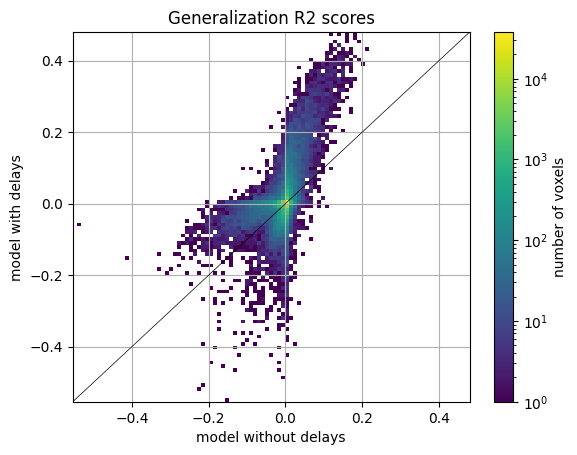

In [16]:
from voxelwise_tutorials.viz import plot_hist2d

ax = plot_hist2d(scores_no_delay, scores)
ax.set(
    title='Generalization R2 scores',
    xlabel='model without delays',
    ylabel='model with delays',
)
plt.show()

(n_delays, n_features, n_voxels) = (7, 1705, 10)


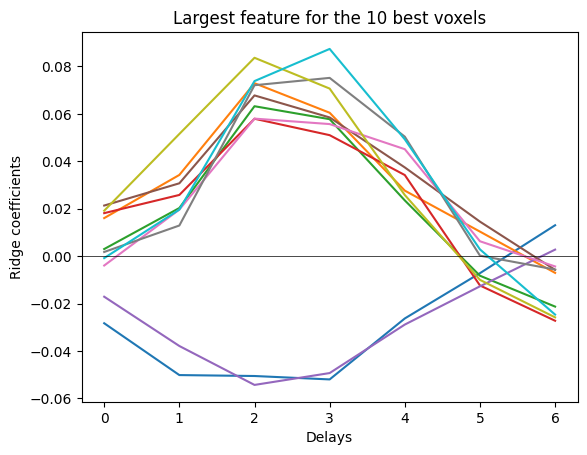

In [17]:
# pick the 10 best voxels
voxel_selection = np.argsort(scores)[-10:]

# define a pipeline with more delays
pipeline_more_delays = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[0, 1, 2, 3, 4, 5, 6]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)

pipeline_more_delays.fit(X_train, Y_train[:, voxel_selection])

# get the (primal) ridge regression coefficients
primal_coef = pipeline_more_delays[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)

# split the ridge coefficients per delays
delayer = pipeline_more_delays.named_steps['delayer']
primal_coef_per_delay = delayer.reshape_by_delays(primal_coef, axis=0)
print("(n_delays, n_features, n_voxels) =", primal_coef_per_delay.shape)

# select the feature with the largest coefficients for each voxel
feature_selection = np.argmax(np.sum(np.abs(primal_coef_per_delay), axis=0),
                              axis=0)
primal_coef_selection = primal_coef_per_delay[:, feature_selection,
                                              np.arange(len(voxel_selection))]

plt.plot(delayer.delays, primal_coef_selection)
plt.xlabel('Delays')
plt.xticks(delayer.delays)
plt.ylabel('Ridge coefficients')
plt.title(f'Largest feature for the {len(voxel_selection)} best voxels')
plt.axhline(0, color='k', linewidth=0.5)
plt.show()